In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
import qgrid
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
import math


# User defined Functions

In [35]:
def top_features(model):
    features_importance = pd.DataFrame(data={
    'Importance': abs(model.params[1:]),
    'Coefficient': model.params[1:], 'P-value': round(model.pvalues[1:],4)})
    features_importance = features_importance.sort_values(by='Importance', ascending=False)
    return features_importance

def remove_outliers(df,col_list):
    '''Removes outliers from dataframe DF using the 
    IQR * 1.5 rule.  
    Applies only to the columns in list COL_LIST'''
    
    for i in col_list:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)


        df.drop(df[ (df[i] > upper_bound) | (df[i] < lower_bound) ].index , inplace=True)
        return(df)

#Get independent variable
def create_y(df,y_name):
    y=df[y_name]
    return y

#get dependent variable
def create_x(df,y_name):
    x=df.drop(labels=y_name,axis=1)
    return x

#Create train-test x,ys
def create_train_test_data(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.30,random_state=123)
    return x_train,x_test,y_train,y_test

#Create ColumnTransformer to enable transforming of both numerical & categorical data
def col_transformer(x): 

    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)

    numerical_columns = numerical_columns_selector(x)
    categorical_columns = categorical_columns_selector(x)


    categorical_preprocessor = OneHotEncoder(drop='first',handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()


    preprocessor = ColumnTransformer([('cat', categorical_preprocessor, categorical_columns),
                                      ('num', numerical_preprocessor, numerical_columns)],sparse_threshold=0)
    return preprocessor


#Run statmodel OLS
def sm_OLS(x_train_scaled,x_test_scaled,y_train):
    x_train_const_scaled = sm.add_constant(x_train_scaled) # adding a constant so that formula understands y=mx+b that b<>0
    model = sm.OLS(y_train, x_train_const_scaled).fit()
    y_pred_train = model.predict(x_train_const_scaled) 

    x_test_const_scaled = sm.add_constant(x_test_scaled) # adding a constant so that formula understands y=mx+b that b<>0
    y_pred_test = model.predict(x_test_const_scaled) 
    return model,y_pred_train,y_pred_test

#Collect results for analysis
def gather_results(model,y_pred_train,y_train):
    m_mse=mse(y_train,y_pred_train)
    rmse=math.sqrt(mse(y_train,y_pred_train))
    r_mae=mae(y_train,y_pred_train)
    r_squared=model.rsquared
    r_squared_adj=model.rsquared_adj
    df_data={'MSE':[round(m_mse,2)],'RMSE':[round(rmse,3)],'R-Squared':[round(r_squared,3)],'R-Squared-Adj':[round(r_squared_adj,3)]}
    temp_df=pd.DataFrame(df_data)
    return temp_df

# Import everything

# Read file

In [36]:
file_path=r"..\Data\nutrition_demographic_covid_continent_3 - low GNI.csv"
df_new=pd.read_csv(file_path)

In [37]:
df_new.loc[df_new['gni per capita, atlas method (current us$)']<12600, 'gni_real'] = 'mid_gni'
df_new.loc[df_new['gni per capita, atlas method (current us$)']<4500, 'gni_real'] = 'low_gni'
df_new.loc[df_new['gni per capita, atlas method (current us$)']>12600, 'gni_real'] = 'high_gni'

In [38]:
df_new['covid_fatality_rate'].describe()
df_new.loc[df_new['covid_fatality_rate']>=67.97,'comparative_fatality_rate']='high_fatality_rate'
df_new.loc[df_new['covid_fatality_rate']<67.97,'comparative_fatality_rate']='low_fatality_rate'

In [39]:
#df_new.to_csv(r'C:\Users\MichaelTaylo_c9zoof3\Documents\GitHub\IH_Berliners\Data\6.gni and comparative death rates\nutrition_demographic_covid_continent_3.csv')

In [40]:
df_high=df_new[df_new['gni_real'].isin(["high_gni"])]
df_low=df_new[df_new['gni_real'].isin(["low_gni"])]

In [41]:
high_comparison=df_high.groupby(['comparative_fatality_rate']).mean()

In [42]:
high_comparison_difference=(high_comparison.iloc[0,:]-high_comparison.iloc[1,:])/high_comparison.iloc[1,:]

In [43]:
high_comparison_difference=pd.DataFrame(high_comparison_difference)
hcd_abs=high_comparison_difference.abs()

In [44]:
qgrid.show_grid(high_comparison,grid_options={'forceFitColumns': False})
hcd_abs.to_csv(r'C:\Users\MichaelTaylo_c9zoof3\Documents\GitHub\IH_Berliners\Data\6.gni and comparative death rates\high_rate_abs.csv')

## Update columnusage

In [45]:


#df=df_low[col_list]
df=df_low.copy()

## Remove columns with high multicolinearity

In [46]:
#Complete the actual removal
def remove_multicollinearity(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return dataset

df=remove_multicollinearity(df,.8)

# Review numerical data

In [47]:
#get numericals
numericals=df._get_numeric_data()

# Code used per project

In [48]:
#Which dataframe did I use?
#col_for_regression=['covid_fatality_rate','age dependency ratio (% of working-age population)','gni per capita, atlas method (current us$)','lifetime risk of maternal death (1 in: rate varies by country)','population ages 00-04, female (% of female population)','population ages 30-34, male (% of male population)','fat_animal products','obesity','kcal_fish, seafood','kcal_vegetable oils']
df_used = numericals.copy()        #numbers only


## Remove outliers

In [49]:
#Remove outliers
outlier_list=numericals.columns
#remove_outliers(df_used,outlier_list)

In [50]:
df_used.shape

(64, 54)

## Create x-y split and check initial outcomes of model

## SHAPELY

In [51]:

#Prep X-Y Split
y_name='covid_fatality_rate'
y=create_y(df_used,y_name)
x=create_x(df_used,y_name)

#Create train-test data
x_train,x_test,y_train,y_test=create_train_test_data(x,y)

#Create transformer to normalize data
transformer=col_transformer(x_train)

#Normalize/scale data
x_train_scaled=transformer.fit_transform(x_train)
x_test_scaled=transformer.transform(x_test)
feature_names=transformer.get_feature_names_out()
x_train_scaled=pd.DataFrame(data=x_train_scaled,columns=feature_names)
x_test_scaled=pd.DataFrame(data=x_test_scaled,columns=feature_names)

#Create OLS model using statsmodel
y_train=y_train.values.reshape(-1,1)
model,y_pred_train,y_pred_test=sm_OLS(x_train_scaled,x_test_scaled,y_train)

#Gather results of the OLS
#y_pred_test=y_pred_test.values.reshape(-1,1)
results_model=gather_results(model,y_pred_train,y_train)
print(results_model)

features_importance=top_features(model)
qgrid.show_grid(features_importance,grid_options={'forceFitColumns': False})


   MSE  RMSE  R-Squared  R-Squared-Adj
0  0.0   0.0        1.0            NaN


divide by zero encountered in true_divide
invalid value encountered in double_scalars


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

# RFE

In [52]:
y_train=y_train.ravel()
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=250)
from sklearn.feature_selection import RFE
# here we want only one final feature, we do this to produce a ranking
n_features_to_select = 20
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(x_train, y_train)

#===========================================================================
# now print out the features in order of ranking
#===========================================================================
from operator import itemgetter
features = x_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 age dependency ratio (% of working-age population)
1 age dependency ratio, old
1 gni per capita, atlas method (current us$)
1 improved water source (% of population with access)
1 lifetime risk of maternal death (%)
1 lifetime risk of maternal death (1 in: rate varies by country)
1 population ages 20-24, female (% of female population)
1 population, female (% of total)
1 rural population growth (annual %)
1 urban population growth (annual %)
1 fat_animal products
1 fat_animal fats
1 fat_eggs
1 fat_fruits - excluding wine
1 fat_meat
1 fat_offals
1 fat_oilcrops
1 fat_stimulants
1 kcal_sugar & sweeteners
1 protein_animal fats
2 rural population (% of total population)
3 fat_starchy roots
4 protein_stimulants
5 kcal_fruits - excluding wine
6 fat_pulses
7 population ages 30-34, female
8 diabetes prevalence (% of population ages 20 to 79)
9 fat_cereals - excluding beer
10 average_immunizatio
11 kcal_vegetable oils
12 fat_fish, seafood
13 obesity
14 protein_oilcrops
15 age population, age 0

# Re-run code with RFE

In [53]:
col_list=[]
for i in features[0:30]:
    col_list.append(i)
col_list.append('covid_fatality_rate')

df=df_low[col_list]

#get numericals
numericals=df._get_numeric_data()
#Which dataframe did I use?
#col_for_regression=['covid_fatality_rate','age dependency ratio (% of working-age population)','gni per capita, atlas method (current us$)','lifetime risk of maternal death (1 in: rate varies by country)','population ages 00-04, female (% of female population)','population ages 30-34, male (% of male population)','fat_animal products','obesity','kcal_fish, seafood','kcal_vegetable oils']
df_used = numericals.copy()        #numbers only
df_used.shape


(64, 31)

In [54]:
keep_going=True

while keep_going==True:
   #Prep X-Y Split
    y_name='covid_fatality_rate'
    y=create_y(df_used,y_name)
    x=create_x(df_used,y_name)

    #Create train-test data
    x_train,x_test,y_train,y_test=create_train_test_data(x,y)

    #Create transformer to normalize data
    transformer=col_transformer(x_train)

    #Normalize/scale data
    x_train_scaled=transformer.fit_transform(x_train)
    x_test_scaled=transformer.transform(x_test)
    feature_names=transformer.get_feature_names_out()
    x_train_scaled=pd.DataFrame(data=x_train_scaled,columns=feature_names)
    x_test_scaled=pd.DataFrame(data=x_test_scaled,columns=feature_names)

    #Create OLS model using statsmodel
    y_train=y_train.values.reshape(-1,1)
    model,y_pred_train,y_pred_test=sm_OLS(x_train_scaled,x_test_scaled,y_train)

    #Gather results of the OLS
    #y_pred_test=y_pred_test.values.reshape(-1,1)
    results_model=gather_results(model,y_pred_train,y_train)
    print(results_model)
    
    #remove stepwise feature.  if done is written, stop removing
    features_importance=top_features(model)
    temp_features=features_importance.sort_values(by='P-value', ascending=False)
    worst_feature=temp_features.iloc[0,:]
    print(worst_feature)
    worst_feature=str(worst_feature.name)
    if temp_features.iloc[0,2]<=.07:
        keep_going=False
    else:
        stp=r'num_'
        worst_feature=worst_feature.strip('num').strip('_')
        df_used.drop(labels=worst_feature,axis=1,inplace=True)
        df_used.columns

      MSE    RMSE  R-Squared  R-Squared-Adj
0  970.03  31.145      0.883          0.613
Importance     0.695502
Coefficient   -0.695502
P-value        0.972700
Name: num__lifetime risk of maternal death (%), dtype: float64
      MSE    RMSE  R-Squared  R-Squared-Adj
0  970.12  31.147      0.883           0.64
Importance     1.951093
Coefficient   -1.951093
P-value        0.949900
Name: num__people practicing open defecation (% of population), dtype: float64
     MSE    RMSE  R-Squared  R-Squared-Adj
0  970.4  31.151      0.883          0.664
Importance     1.581351
Coefficient    1.581351
P-value        0.936200
Name: num__rural population (% of total population), dtype: float64
      MSE    RMSE  R-Squared  R-Squared-Adj
0  970.83  31.158      0.883          0.685
Importance     2.968397
Coefficient    2.968397
P-value        0.881000
Name: num__improved water source, urban (% of urban population with access), dtype: float64
      MSE    RMSE  R-Squared  R-Squared-Adj
0  972.23  31.18

# Model summary post RFE

In [55]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     16.94
Date:                Fri, 01 Jul 2022   Prob (F-statistic):           1.13e-09
Time:                        12:14:02   Log-Likelihood:                -228.86
No. Observations:                  44   AIC:                             473.7
Df Residuals:                      36   BIC:                             488.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                              59.7784      7.320      8.166      0.000      44.933      74.624
num__age dependency ratio, old                     71.0963     12.535      5.672      0.000      45.674      96.518
num__gni per capita, atlas method (current us$)    31.0184     14.283      2.172      0.037       2.052      59.985
num__improved sanitation facilities               -34.0147     14.387     -2.364      0.024     -63.193      -4.836
num__population ages 30-34, female                 34.6879     10.750      3.227      0.003      12.886      56.490
num__rural population growth (annual %)            25.9340     11.966      2.167      0.037       1.667      50.201
num__fat_animal fats                               20.7649     10.969      1.893      0.066      -1.481      43.011
num__fat_fish, seafood                            -24.1360      9.044     -2.669      0.011     -42.478      -5.794
==============================================================================
Omnibus:                        5.208   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                3.957
Skew:                           0.600   Prob(JB):                        0.138
Kurtosis:                       3.847   Cond. No.                         5.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

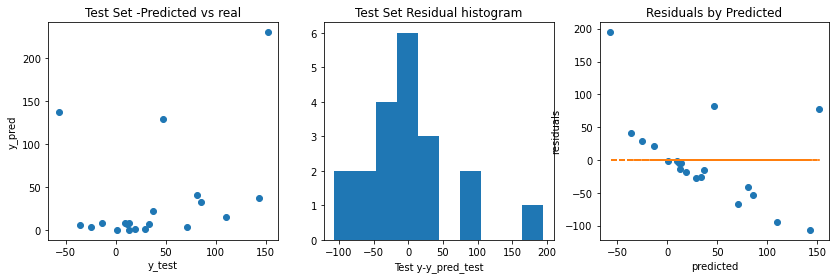

In [56]:
# Make an scatter plot y_pred vs y. Should be close to a straight line
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred_test, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")
# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
y_test.reset_index(drop=True,inplace=True)
ax[1].hist(y_test - y_pred_test)
ax[1].set_xlabel("Test y-y_pred_test")
ax[1].set_title("Test Set Residual histogram")
ax[2].plot(y_pred_test,y_test - y_pred_test,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred_test,np.zeros(len(y_pred_test)),linestyle='dashed')


<AxesSubplot:xlabel='y_pred_test', ylabel='y_test'>

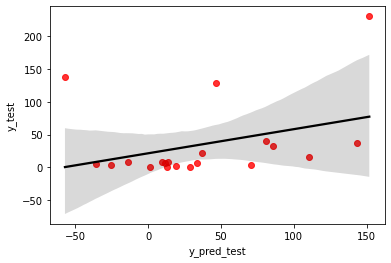

In [57]:
result=pd.DataFrame({"y_test":y_test,"y_pred_test":y_pred_test})

sns.regplot(x='y_pred_test',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

In [58]:
y_train=y_train.ravel()

In [59]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)

model.fit(x_train_scaled, y_train)

y_pred_test=model.predict(x_test_scaled)


In [60]:
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# import shap library
import shap

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

# visualize the first prediction's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

In [61]:
shap.force_plot(explainer.expected_value, shap_values, x_train)

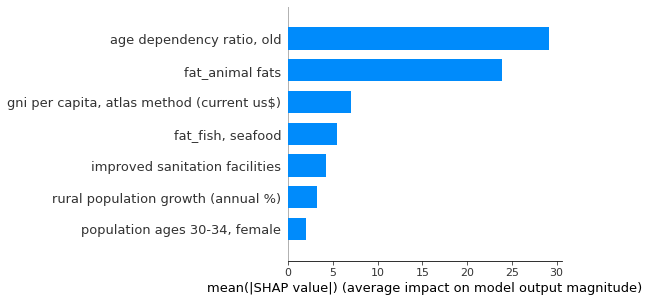

In [62]:
shap_values = shap.TreeExplainer(model).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

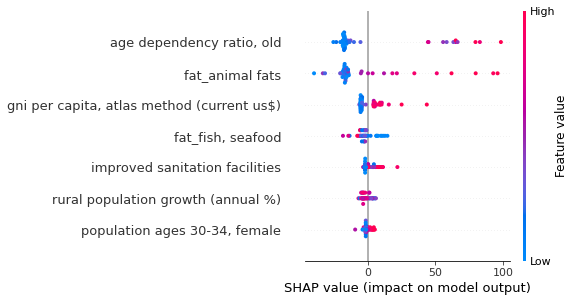

In [63]:
shap.summary_plot(shap_values, x_train)

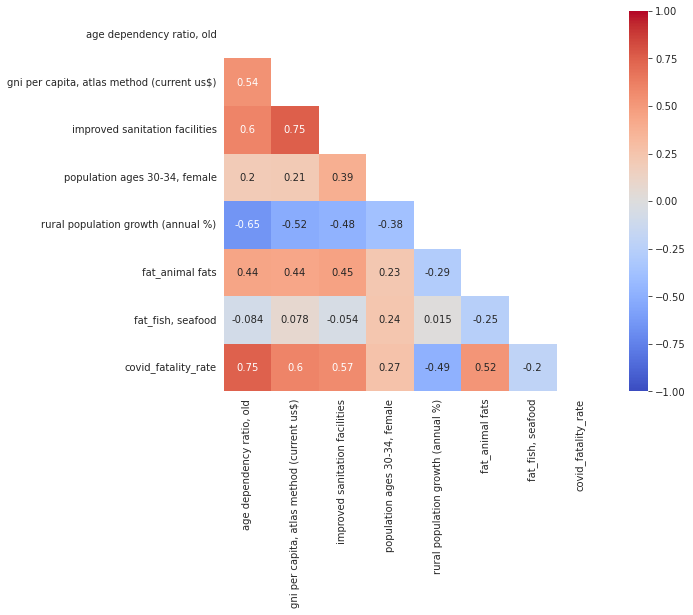

In [64]:
corr = df_used.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

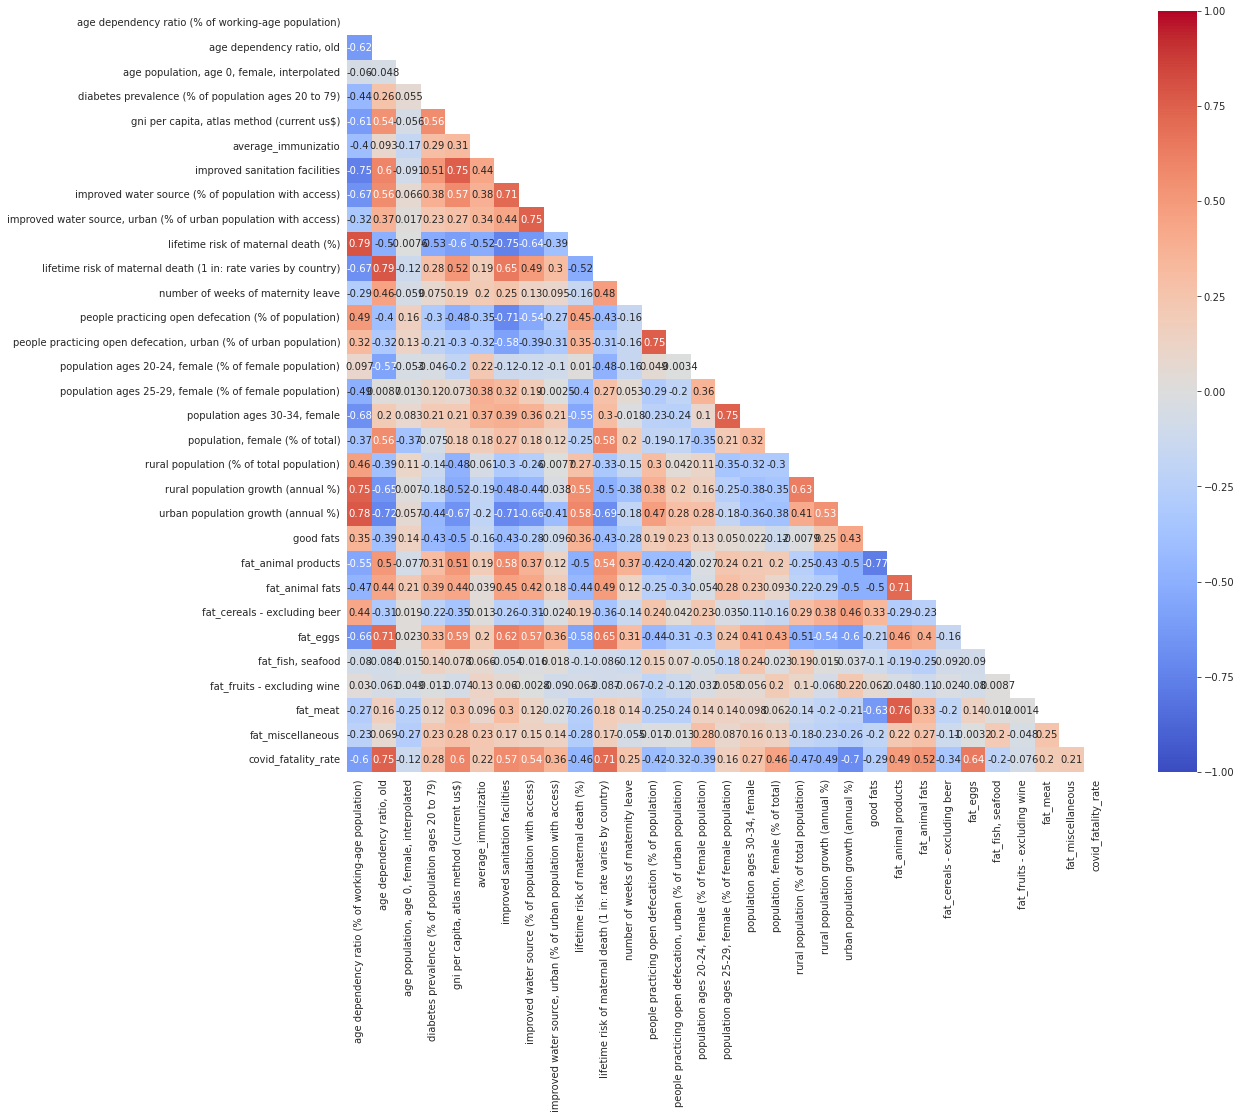

In [65]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(18, 14))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)